In [2]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from system import *
import scqubits
import colorednoise as cn
from scipy.optimize import golden
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, trunc):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-6
        self.trunc = trunc
        self.total_dim = trunc[-1]*trunc[-2]
        self.get_H()
        self.get_H_der()
        self.get_noise_operator()
        self.get_projectors()
        
        

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)

        
    def get_indices(self, dims):
        """
        Convert a list of 2D indices to 1D indices based on given dimensions.
        
        Args:
            dims: List of two integers [N,K] specifying the dimensions to include
                 N is number of cavity states
                 K is number of SNAIL states
                 
        Returns:
            List of 1D indices corresponding to the 2D indices
        """
        N, K = dims
        indices_2d = []
        indices_1d = []
        
        # Generate all 2D indices and store indices outside truncation
        for n in range(self.sdim):
            for k in range(self.cdim):
                # Only add indices that are outside the truncation
                if n >= N or k >= K:
                    indices_2d.append(f"{n}{k}")
                    # Convert to 1D index using n*cdim + k
                    idx = n*self.cdim + k
                    indices_1d.append(idx)

        return indices_1d
        
    def remove_row_col(self, matrix, indices):
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square")
        
        # Convert single index to list if needed
        if isinstance(indices, (int, np.integer)):
            indices = [indices]
            
        # Convert to list if numpy array
        if isinstance(indices, np.ndarray):
            indices = indices.tolist()
            
        # Sort indices in descending order to avoid changing indices when deleting
        indices = sorted(indices, reverse=True)
        
        # Check if indices are valid
        if any(i < 0 or i >= matrix.shape[0] for i in indices):
            raise ValueError(f"All indices must be between 0 and {matrix.shape[0]-1}")
        
        # Remove rows and columns
        result = matrix.copy()
        for idx in indices:
            result = np.delete(np.delete(result, idx, axis=0), idx, axis=1)
            
        return result
    
    def truncate_matrix(self, matrix, trunc):
        indices = self.get_indices(trunc)
        return self.remove_row_col(matrix, indices)
    
    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf, noise = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        self.Hs = Hs
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control,noise = composite_sys(squid,cavity,noise)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()
        self.U1 = U
        self.Ud1 = Ud

        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control
        self.noise = noise

        cavity_sigmax = np.zeros((self.cdim, self.cdim))
        cavity_sigmax[0,1] = 1
        cavity_sigmax[1,0] = 1
        sigmaxc = np.kron(np.eye(self.sdim), cavity_sigmax)
        self.sigmaxc = self.truncate_matrix(sigmaxc, self.trunc)
        squid_sigmax = np.zeros((self.sdim, self.sdim))
        squid_sigmax[0,1] = 1
        squid_sigmax[1,0] = 1
        sigmaxs = np.kron(squid_sigmax, np.eye(self.cdim))
        self.sigmaxs = self.truncate_matrix(sigmaxs, self.trunc)
    
    
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf,noise = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control,noise = composite_sys(squid,cavity,noise)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()

        self.H_per = H
        self.H_control_per = H_control

        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]

    def get_noise_operator(self):
        H_per = self.H_per
        H = self.H
        self.noise1 = (H_per - H) / self.epsilon
        # s = self.annihilation(self.sdim)
        # sd = self.creation(self.sdim)
        # ic = np.identity(self.cdim)
        # self.noise = self.truncate_matrix(np.kron(sd@s, ic), self.trunc)
        self.noise1 = self.Ud1@self.noise1@self.U1
        self.noise1 = self.truncate_matrix(self.noise1, self.trunc)

        self.noise = self.Ud1@self.noise@self.U1
        self.noise = self.truncate_matrix(self.noise, self.trunc)


        self.H = self.Ud1@self.H@self.U1
        self.H = self.truncate_matrix(self.H, self.trunc)
        self.H_control = self.Ud1@self.H_control@self.U1
        self.H_control = self.truncate_matrix(self.H_control, self.trunc)
    
    def get_projectors(self):
        trunc = self.trunc
        truncated_total_dim = trunc[-1]*trunc[-2]
        projectors = []
        for i in range(truncated_total_dim):
            projector = qt.basis(truncated_total_dim, i)*qt.basis(truncated_total_dim, i).dag()

            projectors.append(projector)
        self.projectors = projectors
        

    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def calculate_dr_exact(self, A, omega):
        energy01,energy02,energy03= calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy01_,energy02_,energy03_ = calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy01_ - energy01) / self.epsilon
        return self.static_rate(der1)

    
    def optimal_omegad(self, A):
        # Create a wrapper function that ensures we return a Python float
        def calculate_dr_wrapper(A, omega_d):
            result = self.calculate_dr_exact(A, omega_d)
            return float(result)

        # Define objective function
        def objective(omega_d):
            return calculate_dr_wrapper(A, omega_d)

        # Try different bracketing values until we find ones that work
        omega_min = 5.8 * 2 * np.pi
        omega_max = 6.4 * 2 * np.pi
        n_points = 10
        omega_range = np.linspace(omega_min, omega_max, n_points)
        
        # Find minimum point among test points
        rates = [objective(omega) for omega in omega_range]
        min_idx = np.argmin(rates)
        
        if min_idx == 0 or min_idx == len(omega_range)-1:
            # If minimum is at edge, return that value
            optimal_omega = omega_range[min_idx]
            min_rate = rates[min_idx]
        else:
            # Use points around minimum for bracketing
            xa = omega_range[min_idx-1]
            xb = omega_range[min_idx]
            xc = omega_range[min_idx+1]
            
            # Use golden section search for optimization
            optimal_omega = golden(objective, brack=(xa, xb, xc))
            min_rate = objective(optimal_omega)
        
        return optimal_omega/2/np.pi, min_rate
    

    def calculate_floquet_U(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        self.sigmax_dressed = Ud@self.sigmaxc@U
        initial_state = np.sqrt(1/2)*(U[:,0] + U[:,1])
        return initial_state, self.sigmax_dressed,
    
    def calculate_floquet_U_test(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        noise = Ud@self.noise@U
        H = Ud@self.H@U
        H_control = Ud@self.H_control@U
        return noise, H, H_control

    def setup_floquet_system(self, A, optimal_omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / optimal_omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': optimal_omega})
        
        def state_and_sigmax(t):
            # Compute Floquet modes and energies
            f_modes = floquet_basis.mode(t)
            f_energies = floquet_basis.e_quasi
            f_modes = np.array(f_modes)
            # Convert list of Qobj to numpy array
            f_modes_array = []
            for mode in f_modes:
                f_modes_array.append(mode.full().flatten())
            f_modes = np.array(f_modes_array)
            f_modes = f_modes.T
            evals, U = sort_eigenpairs(f_energies,f_modes)
            Ud = U.T.conj()

            return U, Ud@self.sigmaxc@U

        U, sigmax = state_and_sigmax(0)
        initial_state = np.sqrt(1/2)*(U[:,0] + U[:,1])
        # initial_state = U[:,0]
        
        def get_projector(U):
            projs = []
            for i in range(U.shape[1]):
                state = qt.Qobj(U[:,i])
                proj = state * state.dag()
                projs.append(proj)
            return projs
            
        return initial_state, state_and_sigmax, get_projector


In [3]:


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 5e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
noise = qt.Qobj(sc.noise)


 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/solver_base.py: 576

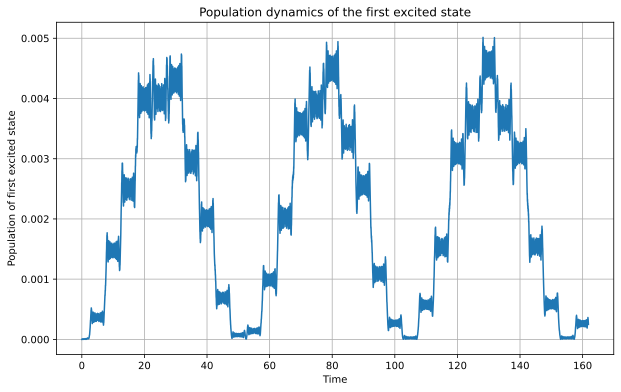

In [5]:

omega = optimal_omega
T = (2 * np.pi) / omega

# Define the Hamiltonian
H = [H0, [A*H_control, lambda t, args: np.cos(args['w'] * t)],[noise, lambda t: np.cos(1e-1*2*np.pi * t) ]]
# Initial state (ground state)
psi0 = qt.basis(2, 0)

# Time points for simulation
tlist = np.linspace(0, 1000*T, 10000)

# Set up the solver with the Floquet Hamiltonian
options = {'nsteps': 200000, 'atol': 1e-13, 'rtol': 1e-13, 'store_states': True}  # Increase nsteps to handle the integration
result = qt.sesolve(H, psi0, tlist, [], args={'w': omega}, options=options)

# Calculate population of the first excited state
excited_state = qt.basis(2, 1)
p_excited = []
for state in result.states:
    p_excited.append(abs(state[1])**2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(tlist, p_excited)
plt.xlabel('Time')
plt.ylabel('Population of first excited state')
plt.title('Population dynamics of the first excited state')
plt.grid(True)
plt.show()


In [6]:
# Set up the Floquet solver
H1 =[H0, [A*H_control, lambda t, args: np.cos(args['w'] * t)]]
floquet_basis = qt.FloquetBasis(H1, T, args={'w': omega})

In [7]:
# Compute Floquet modes and energies
f_modes = floquet_basis.mode(0)
f_energies = floquet_basis.e_quasi

In [8]:
# Compute Floquet modes and energies
f_modes = floquet_basis.mode(0)
f_energies = floquet_basis.e_quasi
f_modes = np.array(f_modes)
# Convert list of Qobj to numpy array
f_modes_array = []
for mode in f_modes:
    f_modes_array.append(mode.full().flatten())
f_modes = np.array(f_modes_array)
f_modes = f_modes.T
evals, U = sort_eigenpairs(f_energies,f_modes)

In [9]:
floquet_basis.mode(0)[0]*floquet_basis.mode(0)[0].dag() 

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.0540106 -7.89165483e-20j -0.00546206+2.25972610e-01j]
 [-0.00546206-2.25972610e-01j  0.9459894 +0.00000000e+00j]]

In [10]:
def match_eigenvalues_to_eigenvectors(evals, U):
    """
    Match eigenvalues to their corresponding eigenvectors and convert eigenvectors to qutip Qobj.
    
    Parameters:
    -----------
    evals : numpy.ndarray
        Array of eigenvalues
    U : numpy.ndarray
        Matrix of eigenvectors, where each column is an eigenvector
        
    Returns:
    --------
    tuple of (list, list)
        First list contains eigenvalues, second list contains corresponding eigenvector Qobjs
    """
    eigenvalues = []
    eigenvectors = []
    for i in range(len(evals)):
        # Convert the eigenvector to a qutip Qobj
        eigenvector_qobj = qt.Qobj(U[:, i].reshape(-1, 1))
        eigenvalues.append(evals[i])
        eigenvectors.append(eigenvector_qobj)
    return eigenvalues, eigenvectors

In [11]:
match_eigenvalues_to_eigenvectors(evals, U)

([np.float64(0.0020040443935123975), np.float64(-0.13317903031806747)],
 [Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
  Qobj data =
  [[0.97261966+0.j        ]
   [0.00562134+0.23233466j]],
  Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
  Qobj data =
  [[-0.00561582+0.23233394j]
   [ 0.97261986+0.j        ]]])

In [12]:
def get_U(t):
    f_modes = floquet_basis.mode(t)
    f_energies = floquet_basis.e_quasi
    f_modes = np.array(f_modes)
    # Convert list of Qobj to numpy array
    f_modes_array = []
    for mode in f_modes:
        f_modes_array.append(mode.full().flatten())
    f_modes = np.array(f_modes_array)
    f_modes = f_modes.T
    evals, U = sort_eigenpairs(f_energies,f_modes)
    evals, floquet_states = match_eigenvalues_to_eigenvectors(evals, U)

    f_modes = floquet_basis.mode(0)
    f_energies = floquet_basis.e_quasi
    f_modes = np.array(f_modes)
    # Convert list of Qobj to numpy array
    f_modes_array = []
    for mode in f_modes:
        f_modes_array.append(mode.full().flatten())
    f_modes = np.array(f_modes_array)
    f_modes = f_modes.T
    evals, U = sort_eigenpairs(f_energies,f_modes)
    evals, floquet_states_0 = match_eigenvalues_to_eigenvectors(evals, U)

    # Calculate the time evolution operator in the Floquet basis
    # U(t) = sum_i exp(-i*E_i*t) |phi_i(t))><phi_i|
    def calculate_time_evolution_operator(t, evals, floquet_states):
        U_t = 0
        for i in range(len(evals)):
            # Calculate exp(-i*E_i*t) |phi_i><phi_i|
            phase_factor = np.exp(-1j * evals[i] * t)
            projection_operator = floquet_states[i] * floquet_states[i].dag()
            U_t += phase_factor * projection_operator
        return U_t
    
    # Calculate U(t) using the time evolution operator
    U_t = calculate_time_evolution_operator(t, evals, floquet_states)
    
    # Return the matrix representation of U(t)
    return U_t

In [13]:
def noise_t(t):
    U_t = get_U(t)
    return U_t.dag() @ noise @ U_t

omega = optimal_omega
T = (2 * np.pi) / omega

# Define the Hamiltonian with individual matrix elements for arbitrary dimensions
dim = noise.shape[0]  # Get the dimension of the noise matrix
H_terms = []

# Create basis operators and corresponding time-dependent coefficients
for i in range(dim):
    for j in range(dim):
        # Create the basis operator correctly - can't directly assign to .data
        basis_data = np.zeros((dim, dim), dtype=complex)
        basis_data[i, j] = 1.0
        basis_op = qt.Qobj(basis_data)
        
        # Add the term with its time-dependent coefficient
        H_terms.append([basis_op, lambda t, i=i, j=j: noise_t(t)[i, j]])

# Create the time-dependent Hamiltonian
H = qt.QobjEvo(H_terms)
# Initial state (ground state)
psi0 = qt.basis(2, 0)

# Time points for simulation
tlist = np.linspace(0, 1000*T, 10000)

# Set up the solver with the Floquet Hamiltonian
options = {'nsteps': 10000, 'atol': 1e-13, 'rtol': 1e-13, 'store_states': True}  # Increase nsteps to handle the integration
result = qt.sesolve(H, psi0, tlist, [], args={'w': omega}, options=options)

 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/solver_base.py: 576capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/integrator/scipy_integrator.py", line 69, in _mul_np_vec
Python runtime state: initialized
    out = self.system.matmul_data(t, state)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "qutip/core/cy/qobjevo.pyx", line 1105, in qutip.core.cy.qobjevo.QobjEvo.matmul_data
  File "qutip/core/cy/qobjevo.pyx", line 1117, in qutip.core.cy.qobjevo.QobjEvo.matmul_data
  File "qutip/core/cy/_element.pyx", line 167, in qutip.core.cy._element._BaseElement.matmul_data_t
  File "qutip/core/cy/_element.pyx", line 367, in qutip.core.cy._element._EvoElement.coeff
  File "qutip/cor

: 